# 1️⃣ Multi-Level Engagement Graph (Full Network)

In [13]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem import WordNetLemmatizer
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import re
import nltk

nltk.download('wordnet')

# LOAD DATA
videos = pd.read_csv("videos_with_sentiment.csv")
comments = pd.read_csv("comments_with_sentiment.csv")
replies = pd.read_csv("replies_with_sentiment.csv")
print("\nData loaded. Shapes:")
print(f"Videos: {videos.shape}, Comments: {comments.shape}, Replies: {replies.shape}")

# HASHTAG PREPROCESSING + LOW-FREQ FILTER
lemmatizer = WordNetLemmatizer()

def preprocess_hashtag(tag):
    tag = tag.lower().strip()
    tag = re.sub(r'[^a-z0-9]', '', tag)
    return lemmatizer.lemmatize(tag)

videos['hashtags_list'] = videos['hashtags'].apply(
    lambda x: [preprocess_hashtag(tag) for tag in str(x).split(',') if tag.strip()] if pd.notna(x) else []
)

# Count hashtag frequency across videos
all_hashtags = [tag for tags in videos['hashtags_list'] for tag in tags]
hashtag_counts = Counter(all_hashtags)
print("\nTop hashtags (pre-filter):", hashtag_counts.most_common(5))

# Filter low-frequency hashtags (<2 occurrences)
MIN_FREQ = 2
filtered_hashtags = [tag for tag, count in hashtag_counts.items() if count >= MIN_FREQ]
print(f"\n{len(filtered_hashtags)} hashtags retained after filtering (freq >= {MIN_FREQ})")

# Update videos with filtered hashtags
videos['hashtags_list'] = videos['hashtags_list'].apply(lambda tags: [t for t in tags if t in filtered_hashtags])


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



✅ Data loaded. Shapes:
Videos: (981, 14), Comments: (78785, 9), Replies: (13883, 10)

✅ Top hashtags (pre-filter): [('sabrinacarpenter', 503), ('short', 160), ('sabrinacarpentertour', 99), ('espresso', 64), ('sabrina', 61)]

✅ 473 hashtags retained after filtering (freq >= 2)


In [18]:
#AGGLOMERATIVE CLUSTERING
vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(2,4))
X = vectorizer.fit_transform(filtered_hashtags)
cosine_sim = cosine_similarity(X)

threshold = 0.4
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=threshold, affinity='precomputed', linkage='average')
labels = clustering.fit_predict(1 - cosine_sim)

hashtag_groups = defaultdict(list)
for tag, label in zip(filtered_hashtags, labels):
    hashtag_groups[label].append(tag)

hashtag_to_group = {tag: f"Group_{label}" for tag, label in zip(filtered_hashtags, labels)}

# PRINT GROUPS IN ASCENDING ORDER
print("\nHashtag Groups (Sorted by Group ID):\n")
for group_id in sorted(hashtag_groups.keys()):
    tags = hashtag_groups[group_id]
    print(f"🔸 Group {group_id} ({len(tags)} hashtags): {', '.join(tags)}")
    print("-" * 60)



✅ Hashtag Groups (Sorted by Group ID):

🔸 Group 0 (4 hashtags): sabrinacarpenter, sabrinacarpentertour, sabrinacarpenternews, sabrinacarpenteracting
------------------------------------------------------------
🔸 Group 1 (2 hashtags): sabrinacarpentersongs, sabrinacarpenterstyle
------------------------------------------------------------
🔸 Group 2 (2 hashtags): singer, singerlife
------------------------------------------------------------
🔸 Group 3 (2 hashtags): youtubeislife, youtubelife
------------------------------------------------------------
🔸 Group 4 (2 hashtags): popqueen, queen
------------------------------------------------------------
🔸 Group 5 (2 hashtags): ladbible, ladbibleentertainment
------------------------------------------------------------
🔸 Group 6 (3 hashtags): songwriting, singersongwriter, songwriter
------------------------------------------------------------
🔸 Group 7 (3 hashtags): hollywood, hollywoodnews, hollywoodlife
----------------------------------

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [ ]:
# BUILD MULTI-LEVEL UNDIRECTED NETWORK
G = nx.Graph()

def clean_node_id(node_id):
    return str(node_id).strip().replace('\n', '').replace('\r', '')

# Hashtag Group Nodes
for group in set(hashtag_to_group.values()):
    G.add_node(group, level=0, type="hashtag_group")

# Channels
for idx, row in videos.iterrows():
    video_id = row['video_id']
    channel = row['channel']
    hashtags = row['hashtags_list']
    if pd.isna(channel) or not hashtags:
        continue

    channel_node = clean_node_id(f"channel::{channel}")
    G.add_node(channel_node, level=1, type="channel")

    seen_groups = set()
    for tag in hashtags:
        group = hashtag_to_group.get(tag)
        if group:
            group = clean_node_id(group)
            if (group, channel_node) not in seen_groups:
                G.add_edge(group, channel_node, weight=1, type="hashtag_to_channel")
                seen_groups.add((group, channel_node))

    unique_groups = list(set([clean_node_id(hashtag_to_group[tag]) for tag in hashtags if tag in hashtag_to_group]))
    for i in range(len(unique_groups)):
        for j in range(i + 1, len(unique_groups)):
            g1, g2 = unique_groups[i], unique_groups[j]
            if G.has_edge(g1, g2):
                G[g1][g2]["weight"] += 1
            else:
                G.add_edge(g1, g2, weight=1, type="hashtag_cooccurrence")

# Commenters
for idx, row in comments.iterrows():
    video_id = row['video_id']
    commenter = row['author']
    if pd.isna(commenter):
        continue

    channel_row = videos[videos['video_id'] == video_id]
    if channel_row.empty:
        continue

    channel = channel_row.iloc[0]['channel']
    channel_node = clean_node_id(f"channel::{channel}")
    commenter_node = clean_node_id(f"commenter::{commenter}")

    G.add_node(commenter_node, level=2, type="commenter")

    if G.has_edge(channel_node, commenter_node):
        G[channel_node][commenter_node]['weight'] += 1
    else:
        G.add_edge(channel_node, commenter_node, weight=1, type="channel_to_commenter")

#Repliers
for idx, row in replies.iterrows():
    parent_author = row['parent_author']
    replier = row['author']
    if pd.isna(parent_author) or pd.isna(replier):
        continue

    parent_node = clean_node_id(f"commenter::{parent_author}")
    replier_node = clean_node_id(f"replier::{replier}")

    G.add_node(replier_node, level=3, type="replier")

    if G.has_edge(parent_node, replier_node):
        G[parent_node][replier_node]['weight'] += 1
    else:
        G.add_edge(parent_node, replier_node, weight=1, type="commenter_to_replier")

print(f"\nNetwork built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# EXPORT FOR GEPHI
nx.write_graphml(G, "influence_network_undirected.graphml")
print("GraphML file exported: 'influence_network_undirected.graphml'")

# CLUSTER SIZE PLOT
plt.hist([len(tags) for tags in hashtag_groups.values()], bins=20)
plt.title("Hashtag Cluster Size Distribution (Filtered & Grouped)")
plt.xlabel("Cluster Size")
plt.ylabel("Frequency")
plt.show()



✅ Louvain detected 765 communities.

📊 Community-Level Report:

=== Community 0 ===
Total Nodes: 751
- Channels: 167
- Hashtag Groups: 384
- Commenters: 167
- Repliers: 33
Top Influencer (by PageRank): Group_0 (0.0031)

Hashtag Groups with Hashtags:
- Group_127:
   • skinnydipping
- Group_148:
   • sdkylid
- Group_87:
   • entertainmentnews
   • usentertainmentnews
   • todayentertainmentnews
- Group_120:
   • breakdown
- Group_172:
   • trendingvideo
- Group_348:
   • shortfacts
- Group_59:
   • musicshorts
   • musicshort
- Group_362:
   • interview
- Group_286:
   • fanmoment
- Group_54:
   • capital
   • capitalstb
- Group_263:
   • popmusic
- Group_375:
   • musicvideo
- Group_139:
   • travel
- Group_70:
   • viralnews
- Group_213:
   • actingcareer
- Group_183:
   • milliebobbybrown
- Group_55:
   • viralmoment
   • viralmoments
- Group_80:
   • sabrinacarpentertrivia
- Group_337:
   • ryanseacrestfoundation
- Group_328:
   • youtubecommunity
- Group_37:
   • youtubetrend
- Gro

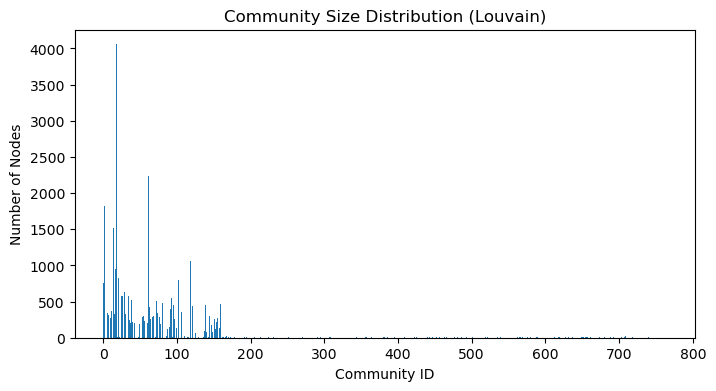


✅ All tasks completed.


In [16]:
import networkx as nx
import pandas as pd
import community as community_louvain
from collections import Counter
import matplotlib.pyplot as plt

# Load the Graph
G = nx.read_graphml("influence_network_undirected.graphml")

# CENTRALITY ANALYSIS

# PageRank
pagerank_scores = nx.pagerank(G, weight='weight')
nx.set_node_attributes(G, pagerank_scores, 'pagerank')

# Betweenness Centrality 
# filter_nodes = [node for node, data in G.nodes(data=True) if data.get('type') in ['channel', 'hashtag_group']]
# subgraph = G.subgraph(filter_nodes)
# betweenness_scores = nx.betweenness_centrality(subgraph, weight='weight', normalized=True)
# nx.set_node_attributes(G, betweenness_scores, 'betweenness')

#LOUVAIN COMMUNITY DETECTION

if G.is_directed():
    G = G.to_undirected()

partition = community_louvain.best_partition(G, weight='weight')
nx.set_node_attributes(G, partition, 'community')

num_communities = len(set(partition.values()))
print(f"\nLouvain detected {num_communities} communities.")

#COMMUNITY-WISE REPORT

node_to_group = {node: data['community'] for node, data in G.nodes(data=True)}

# Categorize nodes
hashtags = [node for node, data in G.nodes(data=True) if data.get('type') == 'hashtag_group']
channels = [node for node, data in G.nodes(data=True) if data.get('type') == 'channel']
commenters = [node for node, data in G.nodes(data=True) if data.get('type') == 'commenter']
repliers = [node for node, data in G.nodes(data=True) if data.get('type') == 'replier']

# Build community details
print("\nCommunity-Level Report:")

empty_communities = []

for comm in sorted(set(partition.values())):
    comm_nodes = [node for node, c in node_to_group.items() if c == comm]
    comm_hashtags = [node for node in comm_nodes if node in hashtags]
    comm_channels = [node for node in comm_nodes if node in channels]
    comm_commenters = [node for node in comm_nodes if node in commenters]
    comm_repliers = [node for node in comm_nodes if node in repliers]
    
    if not comm_hashtags and not comm_channels and not comm_commenters and not comm_repliers:
        empty_communities.append(comm)
        continue

    print(f"\n=== Community {comm} ===")
    print(f"Total Nodes: {len(comm_nodes)}")
    print(f"- Channels: {len(comm_channels)}")
    print(f"- Hashtag Groups: {len(comm_hashtags)}")
    print(f"- Commenters: {len(comm_commenters)}")
    print(f"- Repliers: {len(comm_repliers)}")

    # Top influencer by PageRank
    top_node = max(comm_nodes, key=lambda x: pagerank_scores.get(x, 0))
    print(f"Top Influencer (by PageRank): {top_node} ({pagerank_scores[top_node]:.4f})")

    # Hashtag Groups with actual hashtags
    if comm_hashtags:
        print("\nHashtag Groups with Hashtags:")
        for tag_group in comm_hashtags:
            try:
                group_number = int(tag_group.replace("Group_", ""))
                hashtags_in_group = hashtag_groups.get(group_number, [])
            except ValueError:
                hashtags_in_group = []
            print(f"- {tag_group}:")
            for ht in hashtags_in_group:
                print(f"   • {ht}")

    # Channels
    if comm_channels:
        print("\nChannels:")
        for chan in comm_channels:
            print(f"- {chan}")

    print("-" * 60)

# Print communities with no hashtags or channels
if empty_communities:
    print(f"\n Communities with no hashtags, channels, commenters, or repliers: {', '.join(map(str, empty_communities))}")

# SAVE RESULTS

centrality_data = pd.DataFrame({
    'node': list(G.nodes()),
    'pagerank': [pagerank_scores.get(node, 0) for node in G.nodes()],
    # 'betweenness': [betweenness_scores.get(node, 0) for node in G.nodes()],
    'community': [partition.get(node, -1) for node in G.nodes()],
    'type': [G.nodes[node].get('type', '') for node in G.nodes()],
    'level': [G.nodes[node].get('level', '') for node in G.nodes()]
})

centrality_data.to_csv("centrality_community_summary.csv", index=False)
print("\n Centrality and community data saved to 'centrality_community_summary.csv'.")

# COMMUNITY SIZE PLOT

community_sizes = Counter(partition.values())
plt.figure(figsize=(8,4))
plt.bar(community_sizes.keys(), community_sizes.values())
plt.title("Community Size Distribution (Louvain)")
plt.xlabel("Community ID")
plt.ylabel("Number of Nodes")
plt.show()

print("\n All tasks completed.")


In [7]:
# Export Graph for Gephi with Louvain Communities
nx.write_graphml(G, "influence_network_louvain.graphml")
print("\nGraph with Louvain communities exported: 'influence_network_louvain.graphml'")


✅ Graph with Louvain communities exported: 'influence_network_louvain.graphml'


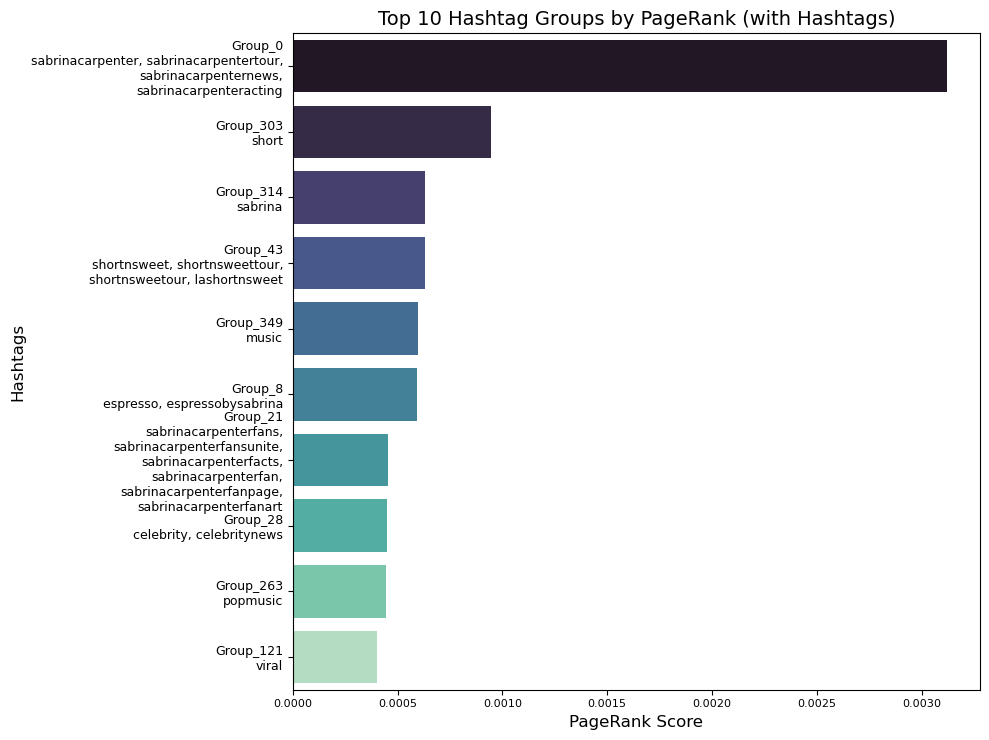

In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

# Load Centrality Data
df = pd.read_csv('centrality_community_summary.csv')

# Filter for hashtag_group nodes
hashtag_df = df[df['type'] == 'hashtag_group']

# Sort by PageRank
top_hashtags = hashtag_df.sort_values('pagerank', ascending=False).head(10).copy()

# Map Group IDs to Hashtags
top_hashtags['hashtags_in_group'] = top_hashtags['node'].apply(
    lambda x: ', '.join(hashtag_groups.get(int(x.replace('Group_', '')), [])) if x.startswith('Group_') else ''
)

# Create Multi-line Labels
def make_multiline_label(row, width=40):
    label = row['node']
    hashtags = row['hashtags_in_group']
    if hashtags:
        wrapped = textwrap.fill(hashtags, width=width)
        return f"{label}\n{wrapped}"
    else:
        return label

top_hashtags['label'] = top_hashtags.apply(make_multiline_label, axis=1)

# Barplot: Top 10 Hashtag Groups by PageRank
plt.figure(figsize=(10, 7.5))
ax = sns.barplot(y='label', x='pagerank', data=top_hashtags, palette='mako')

plt.xlabel('PageRank Score', fontsize=12)
plt.ylabel('Hashtags', fontsize=12)
plt.title('Top 10 Hashtag Groups by PageRank (with Hashtags)', fontsize=14)

plt.xticks(fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=9)

plt.tight_layout()
plt.savefig('top_hashtag_groups_pagerank_with_hashtags_multiline.png', dpi=300)
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_13552\1714634021.py:17: UserWarning: Glyph 127477 (\N{REGIONAL INDICATOR SYMBOL LETTER P}) missing from current font.
  plt.tight_layout()
C:\Users\HP\AppData\Local\Temp\ipykernel_13552\1714634021.py:17: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from current font.
  plt.tight_layout()
C:\Users\HP\AppData\Local\Temp\ipykernel_13552\1714634021.py:18: UserWarning: Glyph 127477 (\N{REGIONAL INDICATOR SYMBOL LETTER P}) missing from current font.
  plt.savefig('top_influencer_channels_pagerank.png')
C:\Users\HP\AppData\Local\Temp\ipykernel_13552\1714634021.py:18: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from current font.
  plt.savefig('top_influencer_channels_pagerank.png')
C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127477 (\N{REGIONAL INDICATOR SYMBOL LETTER P}) missing from current font.
  fig.canvas.print_figure(byt

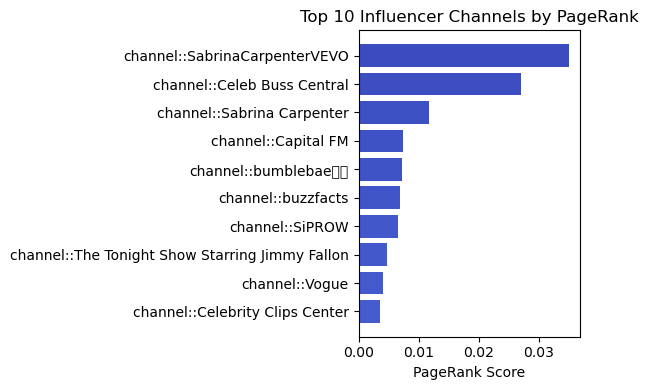

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

# Load Data
df = pd.read_csv('centrality_community_summary.csv')

# Top 10 Influencer Channels by PageRank
top_channels = df[df['type'] == 'channel'].sort_values('pagerank', ascending=False).head(10)

plt.figure(figsize=(6,4))
plt.barh(top_channels['node'], top_channels['pagerank'], color=plt.cm.coolwarm(range(10)))
plt.xlabel('PageRank Score')
plt.title('Top 10 Influencer Channels by PageRank')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('top_influencer_channels_pagerank.png')
plt.show()

# 2️⃣ Year-Wise Sentiment-Weighted User Engagement Graphs:

In [57]:
import pandas as pd
import networkx as nx
from community import community_louvain
from tqdm import tqdm
import os
import numpy as np

#Load Your CSV Files
print("\nLoading CSV files...")
comments = pd.read_csv('comments_with_sentiment_updated.csv')
replies = pd.read_csv('replies_with_sentiment_updated.csv')
videos = pd.read_csv('videos_with_sentiment_updated.csv')
edges = pd.read_csv('edges_combined.csv')
print("CSV files loaded.")

# Normalize Sentiment Function
def normalize_sentiment(s):
    return max(0.01, (s + 1) / 2)

print("\nSentiment normalization function defined (vader_score scaled to [0.01, 1]).")

# Add Year Column to Videos
print("\n Processing year information...")
videos['published'] = pd.to_datetime(videos['published'], errors='coerce')
videos['year'] = videos['published'].dt.year

# === Build Channel Label Map (Channel Name > channelId) ===
print("\nPreparing channel ID to label mapping...")
videos['label'] = videos['channel']
videos.loc[videos['label'].isnull() | (videos['label'].str.lower() == 'unknown'), 'label'] = videos['channelId']
channel_map = videos[['channelId', 'label']].drop_duplicates().set_index('channelId')['label'].to_dict()
print("Channel label mapping ready.")

# === Build Video Title Map ===
video_title_map = videos[['video_id', 'title']].drop_duplicates().set_index('video_id')['title'].to_dict()

# === Merge Year Info into Comments and Replies ===
comments = comments.merge(videos[['video_id', 'year']], on='video_id', how='left')
replies = replies.merge(videos[['video_id', 'year']], on='video_id', how='left')

all_years = sorted(comments['year'].dropna().unique())
print(f"Years detected in data: {all_years}")

# === Build Graphs Year by Year ===
for year in all_years:
    print(f"\nBuilding engagement graph for {year}...")

    comments_year = comments[comments['year'] == year]
    replies_year = replies[replies['year'] == year]
    videos_year = videos[videos['year'] == year]

    G_year = nx.DiGraph()

    # Add Nodes
    for user in tqdm(pd.concat([comments_year['author'], replies_year['author'], replies_year['parent_author']]).dropna().unique(), desc=f"{year}: Adding user nodes"):
        G_year.add_node(user, type='user')

    for _, row in tqdm(videos_year.iterrows(), total=len(videos_year), desc=f"{year}: Adding video & channel nodes"):
        video_id = row['video_id']
        channel_id = row['channelId']
        channel_label = channel_map.get(channel_id, channel_id)
        video_title = video_title_map.get(video_id, video_id)

        G_year.add_node(video_id, type='video', label=video_title)
        G_year.add_node(channel_id, type='channel', label=channel_label)

        # Connect channel to video (engagement flow starts here, neutral weight)
        G_year.add_edge(channel_id, video_id, weight=0.5)

    all_hashtags = set()
    for tag_list in tqdm(videos_year['hashtags'].dropna(), desc=f"{year}: Collecting hashtags"):
        hashtags = [tag.strip().lower() for tag in str(tag_list).split(',') if tag.strip()]
        all_hashtags.update(hashtags)
    for tag in tqdm(all_hashtags, desc=f"{year}: Adding hashtag nodes"):
        G_year.add_node(tag, type='hashtag')

    # Add Edges: Use sentiment only from comments and replies
    for _, row in tqdm(comments_year.iterrows(), total=len(comments_year), desc=f"{year}: Adding User-Video edges (comments)"):
        if pd.notnull(row['author']) and pd.notnull(row['video_id']):
            G_year.add_edge(row['author'], row['video_id'], weight=normalize_sentiment(row['vader_score']))

    for _, row in tqdm(replies_year.iterrows(), total=len(replies_year), desc=f"{year}: Adding User-User edges (replies)"):
        if pd.notnull(row['author']) and pd.notnull(row['parent_author']):
            G_year.add_edge(row['author'], row['parent_author'], weight=normalize_sentiment(row['vader_score']))

    for _, row in tqdm(videos_year.iterrows(), total=len(videos_year), desc=f"{year}: Adding Video-Hashtag edges (neutral weight)"):
        if pd.notnull(row['hashtags']):
            hashtags = [tag.strip().lower() for tag in str(row['hashtags']).split(',') if tag.strip()]
            for tag in hashtags:
                G_year.add_edge(row['video_id'], tag, weight=0.5)

    for _, row in tqdm(edges.iterrows(), total=len(edges), desc=f"{year}: Adding Channel-Channel edges"):
        if pd.notnull(row['source_channelId']) and pd.notnull(row['target_channelId']):
            src = row['source_channelId']
            tgt = row['target_channelId']
            G_year.add_node(src, type='channel', label=channel_map.get(src, src))
            G_year.add_node(tgt, type='channel', label=channel_map.get(tgt, tgt))
            G_year.add_edge(src, tgt, weight=max(row['mention_count'], 0.01))

    print(f"{year}: Graph built with {G_year.number_of_nodes()} nodes and {G_year.number_of_edges()} edges.")

    # PageRank
    print(f"Computing PageRank for {year}...")
    pagerank = nx.pagerank(G_year, weight='weight')
    nx.set_node_attributes(G_year, pagerank, 'pagerank')

    # Louvain Community Detection
    print(f"Running Louvain Community Detection for {year}...")
    partition = community_louvain.best_partition(G_year.to_undirected(), weight='weight')
    partition = {str(k): str(v) for k, v in partition.items()}
    nx.set_node_attributes(G_year, partition, 'community')

    # Compute Community Sentiment Profiles
    sentiments = {}
    for u, v, d in G_year.edges(data=True):
        comm = G_year.nodes[u].get('community')
        if comm is not None:
            sentiments.setdefault(comm, []).append(float(d.get('weight', 0.5)))
    community_avg = {k: np.mean(v) for k, v in sentiments.items()}
    community_type = {k: 'Fanbase' if v >= 0.6 else 'Critics' if v <= 0.4 else 'Mixed' for k, v in community_avg.items()}

    # Export Community Mapping (for IC model)
    community_df = pd.DataFrame([
        {
            'node': node,
            'community': G_year.nodes[node].get('community', 'NA'),
            'community_type': community_type.get(G_year.nodes[node].get('community', 'NA'), 'Unknown')
        }
        for node in G_year.nodes()
    ])
    community_df.to_csv(f"outputs/yearly_graphs/community_nodes_{year}.csv", index=False)

    print(f"Community data saved for {year}.")

    # Print Top PageRank Influencers
    print(f"\nTop 5 Influencers by PageRank ({year}):")
    top_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:5]
    for node, pr in top_pagerank:
        label = G_year.nodes[node].get('label', node)
        print(f"Node: {label}, PageRank: {round(pr,4)}")

    # Export GraphML
    os.makedirs("outputs/yearly_graphs", exist_ok=True)
    G_year_undirected = G_year.to_undirected()
    nx.write_graphml(G_year_undirected, f"outputs/yearly_graphs/sabrina_youtube_{year}_undirected.graphml")
    print(f"GraphML (undirected) exported for {year} to outputs/yearly_graphs/sabrina_youtube_{year}_undirected.graphml")

print("\nYearly graphs built successfully! Check the 'outputs/yearly_graphs' folder for files.")



🔄 Loading CSV files...
✅ CSV files loaded.

✅ Sentiment normalization function defined (vader_score scaled to [0.01, 1]).

🔄 Processing year information...

🔄 Preparing channel ID to label mapping...
✅ Channel label mapping ready.
📅 Years detected in data: [2014.0, 2015.0, 2016.0, 2017.0, 2018.0, 2019.0, 2020.0, 2021.0, 2022.0, 2023.0, 2024.0, 2025.0]

🔄 Building engagement graph for 2014.0...


2014.0: Adding User-User edges (replies): 100%|██████████████████████████████████████| 26/26 [00:00<00:00, 6502.02it/s]
2014.0: Adding Video-Hashtag edges (neutral weight): 100%|█████████████████████████████| 4/4 [00:00<00:00, 2103.20it/s]
2014.0: Adding Channel-Channel edges: 100%|██████████████████████████████████████| 3584/3584 [00:00<00:00, 7708.19it/s]


✅ 2014.0: Graph built with 4523 nodes and 3420 edges.
🔄 Computing PageRank for 2014.0...
🔄 Running Louvain Community Detection for 2014.0...
✅ Community data saved for 2014.0.

🌟 Top 5 Influencers by PageRank (2014.0):
Node: Sabrina Carpenter - Can't Blame a Girl for Trying (Official Video), PageRank: 0.0112
Node: Sabrina Carpenter - The Middle of Starting Over (Official Video), PageRank: 0.0104
Node: officialmusicvideo, PageRank: 0.0038
Node: sabrinacarpenter, PageRank: 0.0038
Node: vevo, PageRank: 0.0038
✅ GraphML (undirected) exported for 2014.0 to outputs/yearly_graphs/sabrina_youtube_2014.0_undirected.graphml

🔄 Building engagement graph for 2015.0...


2015.0: Adding video & channel nodes: 100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 2226.67it/s]
2015.0: Collecting hashtags: 0it [00:00, ?it/s]
2015.0: Adding hashtag nodes: 0it [00:00, ?it/s]
2015.0: Adding User-User edges (replies): 100%|██████████████████████████████████████| 25/25 [00:00<00:00, 1844.79it/s]
2015.0: Adding Video-Hashtag edges (neutral weight): 100%|█████████████████████████████| 3/3 [00:00<00:00, 1483.48it/s]
2015.0: Adding Channel-Channel edges: 100%|██████████████████████████████████████| 3584/3584 [00:00<00:00, 7667.96it/s]


✅ 2015.0: Graph built with 4503 nodes and 3416 edges.
🔄 Computing PageRank for 2015.0...
🔄 Running Louvain Community Detection for 2015.0...
✅ Community data saved for 2015.0.

🌟 Top 5 Influencers by PageRank (2015.0):
Node: Sabrina Carpenter - Eyes Wide Open (Official Video), PageRank: 0.012
Node: Sabrina Carpenter - We'll Be the Stars (Official Video), PageRank: 0.0109
Node: Sabrina Carpenter, PageRank: 0.0036
Node: @LatinHype., PageRank: 0.0022
Node: @thejessicakaylee, PageRank: 0.002
✅ GraphML (undirected) exported for 2015.0 to outputs/yearly_graphs/sabrina_youtube_2015.0_undirected.graphml

🔄 Building engagement graph for 2016.0...


2016.0: Adding User-User edges (replies): 100%|████████████████████████████████████████████████| 42/42 [00:00<?, ?it/s]
2016.0: Adding Video-Hashtag edges (neutral weight): 100%|██████████████████████████████| 6/6 [00:00<00:00, 384.42it/s]
2016.0: Adding Channel-Channel edges: 100%|██████████████████████████████████████| 3584/3584 [00:00<00:00, 8740.12it/s]


✅ 2016.0: Graph built with 4590 nodes and 3507 edges.
🔄 Computing PageRank for 2016.0...
🔄 Running Louvain Community Detection for 2016.0...
✅ Community data saved for 2016.0.

🌟 Top 5 Influencers by PageRank (2016.0):
Node: Wildside (From "Adventures in Babysitting" (Official Lyric Video)), PageRank: 0.011
Node: Sabrina Carpenter - Smoke and Fire (Official Video), PageRank: 0.0098
Node: Sabrina Carpenter - On Purpose (Official Video), PageRank: 0.0095
Node: Sabrina Carpenter, PageRank: 0.0035
Node: @LatinHype., PageRank: 0.0021
✅ GraphML (undirected) exported for 2016.0 to outputs/yearly_graphs/sabrina_youtube_2016.0_undirected.graphml

🔄 Building engagement graph for 2017.0...


2017.0: Adding video & channel nodes: 100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 2180.09it/s]
2017.0: Collecting hashtags: 0it [00:00, ?it/s]
2017.0: Adding hashtag nodes: 0it [00:00, ?it/s]
2017.0: Adding User-User edges (replies): 100%|████████████████████████████████████| 144/144 [00:00<00:00, 6883.20it/s]
2017.0: Adding Video-Hashtag edges (neutral weight): 100%|█████████████████████████████████████| 11/11 [00:00<?, ?it/s]
2017.0: Adding Channel-Channel edges: 100%|██████████████████████████████████████| 3584/3584 [00:00<00:00, 5881.15it/s]


✅ 2017.0: Graph built with 4933 nodes and 3913 edges.
🔄 Computing PageRank for 2017.0...
🔄 Running Louvain Community Detection for 2017.0...
✅ Community data saved for 2017.0.

🌟 Top 5 Influencers by PageRank (2017.0):
Node: Sabrina Carpenter - Tomorrow Starts Today (Andi Mack Theme Song) (Official Video), PageRank: 0.0119
Node: Sabrina Carpenter - Thumbs (Official Lyric Video), PageRank: 0.0116
Node: Sabrina Carpenter - Why (Official Lyric Video), PageRank: 0.011
Node: Sabrina Carpenter - Thumbs (Official Video), PageRank: 0.0102
Node: Sabrina Carpenter - Thumbs ("Soy Luna" Momento Musical), PageRank: 0.0102
✅ GraphML (undirected) exported for 2017.0 to outputs/yearly_graphs/sabrina_youtube_2017.0_undirected.graphml

🔄 Building engagement graph for 2018.0...


2018.0: Adding User-User edges (replies): 100%|████████████████████████████████████| 122/122 [00:00<00:00, 7292.78it/s]
2018.0: Adding Video-Hashtag edges (neutral weight): 100%|███████████████████████████| 10/10 [00:00<00:00, 1658.29it/s]
2018.0: Adding Channel-Channel edges: 100%|██████████████████████████████████████| 3584/3584 [00:00<00:00, 7003.50it/s]


✅ 2018.0: Graph built with 5008 nodes and 3976 edges.
🔄 Computing PageRank for 2018.0...
🔄 Running Louvain Community Detection for 2018.0...
✅ Community data saved for 2018.0.

🌟 Top 5 Influencers by PageRank (2018.0):
Node: singularact1, PageRank: 0.0191
Node: Sabrina Carpenter Plays With Puppies While Answering Fan Questions, PageRank: 0.0105
Node: Sabrina Carpenter DENIES Dating Corey Fogelmanis Despite PDA & Talks Life After Disney, PageRank: 0.0101
Node: Sabrina Carpenter - Almost Love - Live from Wango Tango 2018, PageRank: 0.0099
Node: Sabrina Carpenter - Sue Me, PageRank: 0.0092
✅ GraphML (undirected) exported for 2018.0 to outputs/yearly_graphs/sabrina_youtube_2018.0_undirected.graphml

🔄 Building engagement graph for 2019.0...


2019.0: Adding User-User edges (replies): 100%|████████████████████████████████████| 153/153 [00:00<00:00, 5697.62it/s]
2019.0: Adding Video-Hashtag edges (neutral weight): 100%|███████████████████████████| 14/14 [00:00<00:00, 4673.32it/s]
2019.0: Adding Channel-Channel edges: 100%|██████████████████████████████████████| 3584/3584 [00:00<00:00, 8144.72it/s]


✅ 2019.0: Graph built with 5284 nodes and 4294 edges.
🔄 Computing PageRank for 2019.0...
🔄 Running Louvain Community Detection for 2019.0...
✅ Community data saved for 2019.0.

🌟 Top 5 Influencers by PageRank (2019.0):
Node: singularact2, PageRank: 0.0149
Node: sabrinacarpenter, PageRank: 0.0143
Node: Alan Walker, Sabrina Carpenter & Farruko  - On My Way, PageRank: 0.0121
Node: Sabrina Carpenter Shares Her Firsts | Teen Vogue, PageRank: 0.0101
Node: onmyway, PageRank: 0.0099
✅ GraphML (undirected) exported for 2019.0 to outputs/yearly_graphs/sabrina_youtube_2019.0_undirected.graphml

🔄 Building engagement graph for 2020.0...


2020.0: Adding User-User edges (replies): 100%|██████████████████████████████████████| 81/81 [00:00<00:00, 4414.14it/s]
2020.0: Adding Video-Hashtag edges (neutral weight): 100%|████████████████████████████| 10/10 [00:00<00:00, 815.71it/s]
2020.0: Adding Channel-Channel edges: 100%|██████████████████████████████████████| 3584/3584 [00:00<00:00, 7365.11it/s]


✅ 2020.0: Graph built with 4798 nodes and 3710 edges.
🔄 Computing PageRank for 2020.0...
🔄 Running Louvain Community Detection for 2020.0...
✅ Community data saved for 2020.0.

🌟 Top 5 Influencers by PageRank (2020.0):
Node: Inside Sabrina Carpenter's home for a Perfect Night In | British Vogue, PageRank: 0.0105
Node: Sabrina Carpenter - Let Me Move You (From the Netflix film Work It/Audio Only), PageRank: 0.0101
Node: Sabrina Carpenter's Guide to DIY Facials and Perfect Eyeliner | Beauty Secrets | Vogue, PageRank: 0.0098
Node: SO MUCH TALENT! (Sabrina Carpenter - Why | Music Video Reaction/Review), PageRank: 0.0079
Node: Zara Larsson - WOW (Remix - Official Music Video) ft. Sabrina Carpenter, PageRank: 0.0071
✅ GraphML (undirected) exported for 2020.0 to outputs/yearly_graphs/sabrina_youtube_2020.0_undirected.graphml

🔄 Building engagement graph for 2021.0...


2021.0: Adding User-User edges (replies): 100%|████████████████████████████████████| 657/657 [00:00<00:00, 9094.22it/s]
2021.0: Adding Video-Hashtag edges (neutral weight): 100%|███████████████████████████| 23/23 [00:00<00:00, 1631.33it/s]
2021.0: Adding Channel-Channel edges: 100%|██████████████████████████████████████| 3584/3584 [00:02<00:00, 1699.04it/s]


✅ 2021.0: Graph built with 5924 nodes and 5139 edges.
🔄 Computing PageRank for 2021.0...
🔄 Running Louvain Community Detection for 2021.0...
✅ Community data saved for 2021.0.

🌟 Top 5 Influencers by PageRank (2021.0):
Node: sabrinacarpenter, PageRank: 0.0212
Node: Olivia Rodrigo, Sabrina Carpenter & Joshua Bassett RELATIONSHIP DRAMA EXPLAINED! Sip that tea!, PageRank: 0.0103
Node: Sabrina Carpenter Responds to Question About Drivers License, PageRank: 0.0086
Node: Sabrina Carpenter Perfects Her British Accent | Interview | Capital, PageRank: 0.0084
Node: Vocal Coach Reacts to Sabrina Carpenter - Skin, PageRank: 0.0081
✅ GraphML (undirected) exported for 2021.0 to outputs/yearly_graphs/sabrina_youtube_2021.0_undirected.graphml

🔄 Building engagement graph for 2022.0...


2022.0: Adding User-User edges (replies): 100%|████████████████████████████████████| 697/697 [00:00<00:00, 8264.86it/s]
2022.0: Adding Video-Hashtag edges (neutral weight): 100%|███████████████████████████| 43/43 [00:00<00:00, 6306.56it/s]
2022.0: Adding Channel-Channel edges: 100%|██████████████████████████████████████| 3584/3584 [00:00<00:00, 8452.00it/s]


✅ 2022.0: Graph built with 7481 nodes and 7009 edges.
🔄 Computing PageRank for 2022.0...
🔄 Running Louvain Community Detection for 2022.0...
✅ Community data saved for 2022.0.

🌟 Top 5 Influencers by PageRank (2022.0):
Node: sabrinacarpenter, PageRank: 0.0409
Node: emailsicantsend, PageRank: 0.0196
Node: becauseilikedaboy, PageRank: 0.0117
Node: Sabrina Carpenter - You're so Vain - Live in Tempe Oct. 12th, 2022, PageRank: 0.0067
Node: Sabrina Carpenter Reacts To A Fan Working Out To Her Album!!!, PageRank: 0.0062
✅ GraphML (undirected) exported for 2022.0 to outputs/yearly_graphs/sabrina_youtube_2022.0_undirected.graphml

🔄 Building engagement graph for 2023.0...


2023.0: Adding User-User edges (replies): 100%|████████████████████████████████████| 877/877 [00:00<00:00, 8427.55it/s]
2023.0: Adding Video-Hashtag edges (neutral weight): 100%|███████████████████████████| 65/65 [00:00<00:00, 8123.41it/s]
2023.0: Adding Channel-Channel edges: 100%|██████████████████████████████████████| 3584/3584 [00:00<00:00, 8600.32it/s]


✅ 2023.0: Graph built with 8319 nodes and 7887 edges.
🔄 Computing PageRank for 2023.0...
🔄 Running Louvain Community Detection for 2023.0...
✅ Community data saved for 2023.0.

🌟 Top 5 Influencers by PageRank (2023.0):
Node: sabrinacarpenter, PageRank: 0.0418
Node: shorts, PageRank: 0.0125
Node: emailsicantsend, PageRank: 0.0111
Node: fruitcake, PageRank: 0.0077
Node: feather, PageRank: 0.0069
✅ GraphML (undirected) exported for 2023.0 to outputs/yearly_graphs/sabrina_youtube_2023.0_undirected.graphml

🔄 Building engagement graph for 2024.0...


2024.0: Adding User-User edges (replies): 100%|██████████████████████████████████| 5527/5527 [00:00<00:00, 8372.19it/s]
2024.0: Adding Video-Hashtag edges (neutral weight): 100%|█████████████████████████| 513/513 [00:00<00:00, 6635.08it/s]
2024.0: Adding Channel-Channel edges: 100%|██████████████████████████████████████| 3584/3584 [00:00<00:00, 8324.75it/s]


✅ 2024.0: Graph built with 28389 nodes and 33202 edges.
🔄 Computing PageRank for 2024.0...
🔄 Running Louvain Community Detection for 2024.0...
✅ Community data saved for 2024.0.

🌟 Top 5 Influencers by PageRank (2024.0):
Node: sabrinacarpenter, PageRank: 0.0379
Node: shorts, PageRank: 0.014
Node: shortnsweet, PageRank: 0.0055
Node: sabrinacarpentertour, PageRank: 0.0054
Node: espresso, PageRank: 0.0051
✅ GraphML (undirected) exported for 2024.0 to outputs/yearly_graphs/sabrina_youtube_2024.0_undirected.graphml

🔄 Building engagement graph for 2025.0...


2025.0: Adding User-User edges (replies): 100%|██████████████████████████████████| 2335/2335 [00:00<00:00, 8468.36it/s]
2025.0: Adding Video-Hashtag edges (neutral weight): 100%|█████████████████████████| 279/279 [00:00<00:00, 5667.81it/s]
2025.0: Adding Channel-Channel edges: 100%|██████████████████████████████████████| 3584/3584 [00:00<00:00, 7980.67it/s]


✅ 2025.0: Graph built with 15148 nodes and 16096 edges.
🔄 Computing PageRank for 2025.0...
🔄 Running Louvain Community Detection for 2025.0...
✅ Community data saved for 2025.0.

🌟 Top 5 Influencers by PageRank (2025.0):
Node: sabrinacarpenter, PageRank: 0.0358
Node: shorts, PageRank: 0.0111
Node: sabrinacarpentertour, PageRank: 0.0071
Node: shortvideo, PageRank: 0.0048
Node: shortsviral, PageRank: 0.0044
✅ GraphML (undirected) exported for 2025.0 to outputs/yearly_graphs/sabrina_youtube_2025.0_undirected.graphml

🎉 Yearly graphs built successfully! Check the 'outputs/yearly_graphs' folder for files.


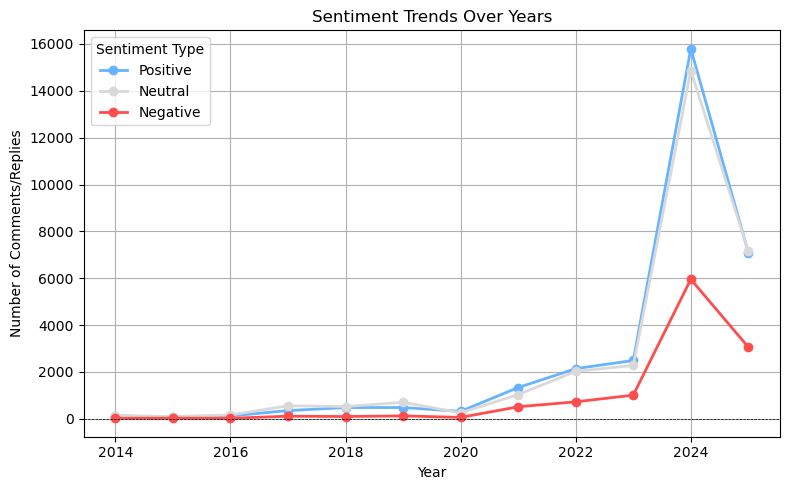


✅ Sentiment trend plot (positive/negative/neutral) saved as 'outputs/sentiment_trend_positive_negative_neutral.png'.


In [123]:
import matplotlib.pyplot as plt
import pandas as pd

# Combine comments and replies for sentiment trend
combined_sentiment = pd.concat([
    comments[['year', 'vader_score']],
    replies[['year', 'vader_score']]
], ignore_index=True)

# Categorize sentiments
def sentiment_label(v):
    norm = max(0.01, (v + 1) / 2)
    if norm >= 0.6:
        return 'Positive'
    elif norm <= 0.4:
        return 'Negative'
    else:
        return 'Neutral'

combined_sentiment['sentiment_label'] = combined_sentiment['vader_score'].apply(sentiment_label)

# Count sentiments per year
sentiment_counts = combined_sentiment.groupby(['year', 'sentiment_label']).size().reset_index(name='count')

# Pivot for plotting
pivot_sentiments = sentiment_counts.pivot(index='year', columns='sentiment_label', values='count').fillna(0).sort_index()

# Plot the trends
plt.figure(figsize=(8,5))
palette = {'Positive': '#66b3ff', 'Neutral': '#d9d9d9', 'Negative': '#ff4d4d'}

for sentiment in ['Positive', 'Neutral', 'Negative']:
    plt.plot(pivot_sentiments.index, pivot_sentiments.get(sentiment, 0), marker='o', linewidth=2, label=sentiment, color=palette[sentiment])

plt.title("Sentiment Trends Over Years")
plt.xlabel("Year")
plt.ylabel("Number of Comments/Replies")
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
plt.legend(title="Sentiment Type")
plt.grid(True)
plt.tight_layout()
plt.savefig("outputs/sentiment_trend_positive_negative_neutral.png", dpi=300)
plt.show()

print("\nSentiment trend plot (positive/negative/neutral) saved as 'outputs/sentiment_trend_positive_negative_neutral.png'.")


In [138]:
import numpy as np

# Community sentiment profiling (use latest graph partition from your loop)
community_sentiments = {}
all_years = sorted(comments['year'].dropna().unique())

for year in all_years:
    print(f"\n🔍 Profiling communities for {year}...")
    graph_path = f"outputs/yearly_graphs/sabrina_youtube_{year}_undirected.graphml"
    G = nx.read_graphml(graph_path)
    
    # Compute community sentiment
    sentiments = {}
    for u, v, d in G.edges(data=True):
        comm = G.nodes[u].get('community')
        if comm:
            sentiments.setdefault(comm, []).append(float(d.get('weight', 0.5)))
    community_avg = {k: np.mean(v) for k, v in sentiments.items()}
    community_type = {k: 'Fanbase' if v >= 0.6 else 'Critics' if v <= 0.4 else 'Mixed' for k, v in community_avg.items()}
    
    summary = pd.DataFrame({
        'Community': community_avg.keys(),
        'Avg Sentiment': community_avg.values(),
        'Type': community_type.values()
    })
    
    summary.to_csv(f"outputs/yearly_graphs/community_summary_{year}.csv", index=False)
    print(summary.head())



🔍 Profiling communities for 2014.0...
  Community  Avg Sentiment     Type
0         0       0.727685  Fanbase
1         1       1.028049  Fanbase
2         2       0.804790  Fanbase
3         3       1.034423  Fanbase
4         4       1.038054  Fanbase

🔍 Profiling communities for 2015.0...
  Community  Avg Sentiment     Type
0         0       0.820774  Fanbase
1        71       1.040918  Fanbase
2         2       1.037500  Fanbase
3         3       0.712888  Fanbase
4         4       1.019355  Fanbase

🔍 Profiling communities for 2016.0...
  Community  Avg Sentiment     Type
0         0       0.777828  Fanbase
1         1       2.229885  Fanbase
2         2       1.030303  Fanbase
3         3       0.908790  Fanbase
4         4       0.937500  Fanbase

🔍 Profiling communities for 2017.0...
  Community  Avg Sentiment     Type
0         0       0.708389  Fanbase
1         1       0.947368  Fanbase
2         2       0.734612  Fanbase
3         3       0.705256  Fanbase
4         4     

Loading CSVs: 100%|████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.87it/s]


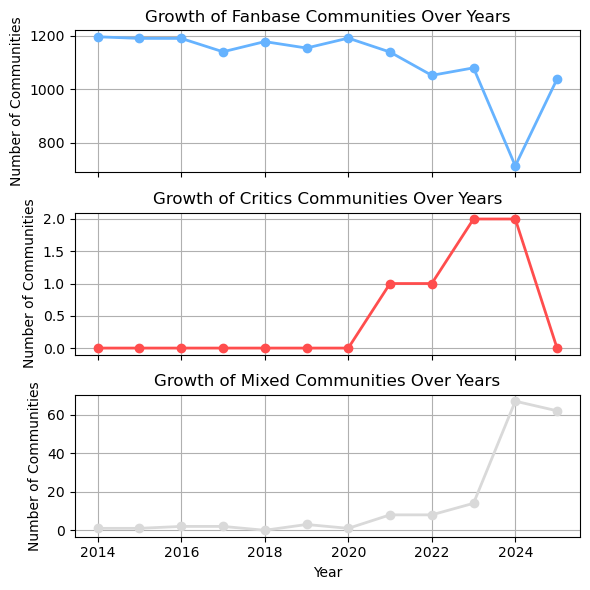


✅ Growth subplots saved as 'outputs/community_type_growth_subplots.png'.


In [139]:
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pandas as pd
from tqdm import tqdm

# Load Community Summaries
all_summaries = []
top_n = 1500  # Number of top communities per year to keep

for file in tqdm(glob.glob("outputs/yearly_graphs/community_summary_*.csv"), desc="Loading CSVs"):
    year = file.split("_")[-1].split(".")[0]
    df = pd.read_csv(file)
    df['year'] = int(year)  # Ensure year is int for sorting

    # Subset: Keep top N communities by Avg Sentiment
    df = df.sort_values(by='Avg Sentiment', ascending=False).head(top_n)
    all_summaries.append(df)

# Combine into single DataFrame
all_summaries_df = pd.concat(all_summaries, ignore_index=True)

# Compute Growth Data
growth_df = all_summaries_df.groupby(['year', 'Type']).size().reset_index(name='count')

# Pivot for separate lines
pivot_df = growth_df.pivot(index='year', columns='Type', values='count').fillna(0).sort_index()

# Create Subplots
fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)

# Define color palette
palette = {'Fanbase': '#66b3ff', 'Mixed': '#d9d9d9', 'Critics': '#ff4d4d'}

# Plot each community type on separate subplot
for ax, comm_type in zip(axes, ['Fanbase', 'Critics', 'Mixed']):
    ax.plot(pivot_df.index, pivot_df.get(comm_type, 0), marker='o', color=palette[comm_type], linewidth=2)
    ax.set_title(f"Growth of {comm_type} Communities Over Years")
    ax.set_ylabel("Number of Communities")
    ax.grid(True)

axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.savefig("outputs/community_type_growth_subplots.png", dpi=300)
plt.show()

print("\nGrowth subplots saved as 'outputs/community_type_growth_subplots.png'.")


In [127]:
import random

def independent_cascade(G, seeds, p=0.1, steps=10):
    active = set(seeds)
    newly_active = set(seeds)
    for _ in range(steps):
        next_new = set()
        for node in newly_active:
            neighbors = set(G.neighbors(node)) - active
            for neighbor in neighbors:
                if random.random() < p:
                    next_new.add(neighbor)
        if not next_new:
            break
        active.update(next_new)
        newly_active = next_new
    return active


In [141]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx
import pandas as pd

ic_results = []

for year in all_years:
    print(f"\nRunning IC Model for {year}...")
    graph_path = f"outputs/yearly_graphs/sabrina_youtube_{year}_undirected.graphml"
    community_path = f"outputs/yearly_graphs/community_summary_{year}.csv"

    # Load Graph and Community Data
    G = nx.read_graphml(graph_path)
    comm_summary = pd.read_csv(community_path)

    # Map community types
    comm_type = dict(zip(comm_summary['Community'].astype(str), comm_summary['Type']))

    # Top influencers by PageRank
    pagerank = nx.get_node_attributes(G, 'pagerank')
    top_nodes = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:5]

    for node, pr in top_nodes:
        # Run IC Model
        seeds = [node]
        active = independent_cascade(G, seeds, p=0.1, steps=10)
        engagement = len(active)

        # Community type of seed
        seed_comm = G.nodes[node].get('community', None)
        seed_type = comm_type.get(str(seed_comm), 'Unknown')

        ic_results.append({
            'year': int(year),  # Now year is int
            'seed_node': node,
            'label': G.nodes[node].get('label', node),
            'pagerank': pr,
            'community': seed_comm,
            'type': seed_type,
            'engagement': engagement
        })

# Convert results to DataFrame
ic_df = pd.DataFrame(ic_results)

# Save CSV
ic_df.to_csv("outputs/independent_cascade_summary.csv", index=False)
print("\nIC model results saved to outputs/independent_cascade_summary.csv")
print(ic_df.head())



🚀 Running IC Model for 2014.0...

🚀 Running IC Model for 2015.0...

🚀 Running IC Model for 2016.0...

🚀 Running IC Model for 2017.0...

🚀 Running IC Model for 2018.0...

🚀 Running IC Model for 2019.0...

🚀 Running IC Model for 2020.0...

🚀 Running IC Model for 2021.0...

🚀 Running IC Model for 2022.0...

🚀 Running IC Model for 2023.0...

🚀 Running IC Model for 2024.0...

🚀 Running IC Model for 2025.0...

✅ IC model results saved to outputs/independent_cascade_summary.csv
   year           seed_node  \
0  2014         HibDj27DHMI   
1  2014         RLcdPpjKKHo   
2  2014  officialmusicvideo   
3  2014    sabrinacarpenter   
4  2014                vevo   

                                               label  pagerank community  \
0  Sabrina Carpenter - Can't Blame a Girl for Try...  0.011153         0   
1  Sabrina Carpenter - The Middle of Starting Ove...  0.010396         2   
2                                 officialmusicvideo  0.003796         2   
3                               

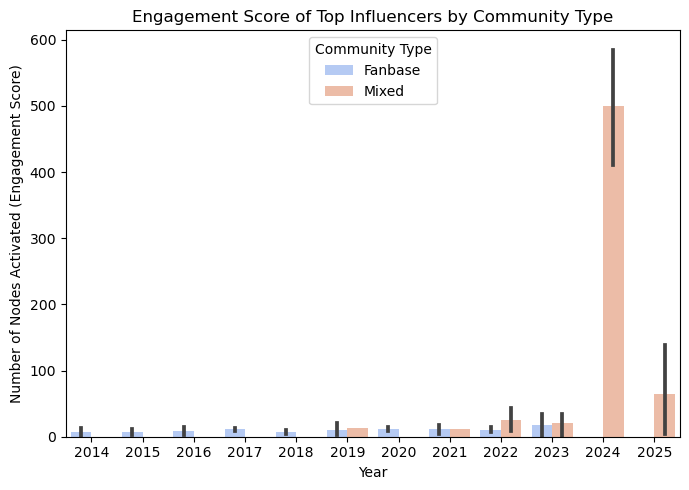

In [142]:
# Barplot: Engagement by Community Type
plt.figure(figsize=(7,5))
sns.barplot(data=ic_df, x='year', y='engagement', hue='type', palette='coolwarm')
plt.title("Engagement Score of Top Influencers by Community Type")
plt.ylabel("Number of Nodes Activated (Engagement Score)")
plt.xlabel("Year")
plt.legend(title="Community Type")
plt.tight_layout()
plt.savefig("outputs/ic_engagement_by_community.png")
plt.show()


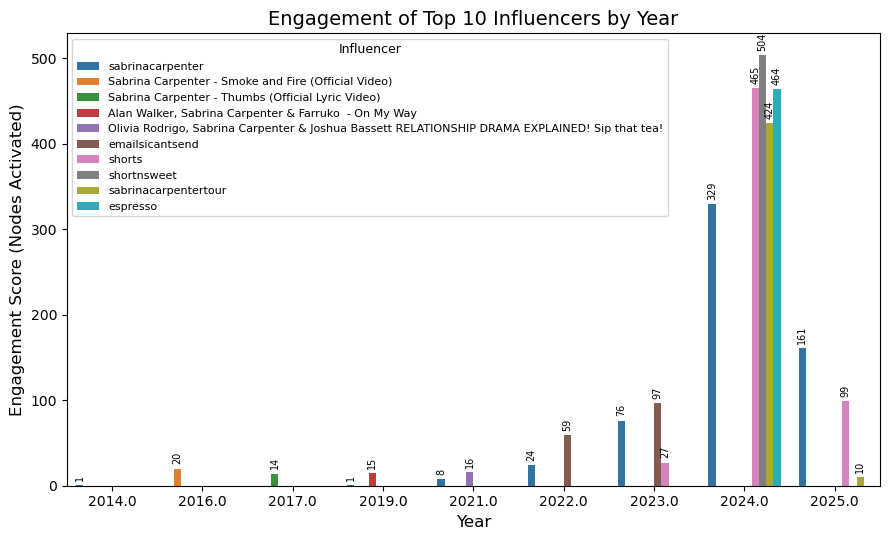

In [145]:
plt.figure(figsize=(9,5.5))
ax = sns.barplot(data=filtered_ic_df, x='year', y='engagement', hue='label', dodge=True)

plt.title("Engagement of Top 10 Influencers by Year", fontsize=14)
plt.ylabel("Engagement Score (Nodes Activated)", fontsize=12)
plt.xlabel("Year", fontsize=12)

plt.legend(title="Influencer", loc='upper left', fontsize=8, title_fontsize=9)

# Add annotations
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height + 5),
                    ha='center', va='bottom', fontsize=7, color='black', rotation=90)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig("outputs/ic_engagement_barlabels_top10.png", dpi=300)
plt.show()
